In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdchem

물리 상수 및 설정

In [2]:
# 원자 속성: [전기음성도(X), 경도(eta), 공유반지름(R), 이온화에너지(IE)]
ATOM_PHYSICS = {
    1: [2.20, 6.42, 0.31, 13.60],  # H
    6: [2.55, 5.00, 0.76, 11.26],  # C
    7: [3.04, 7.27, 0.71, 14.53],  # N
    8: [3.44, 6.08, 0.66, 13.62],  # O
    9: [3.98, 7.01, 0.57, 17.42]   # F
}
ATOM_MAP = {1: 0, 6: 1, 7: 2, 8: 3, 9: 4}

# 혼성 오비탈 인코딩 맵
HYBRID_MAP = {
    rdchem.HybridizationType.S: 0,
    rdchem.HybridizationType.SP: 1,
    rdchem.HybridizationType.SP2: 2,
    rdchem.HybridizationType.SP3: 3,
    rdchem.HybridizationType.SP3D: 4,
    rdchem.HybridizationType.SP3D2: 5,
    rdchem.HybridizationType.UNSPECIFIED: 6
}

KEY_CONFIG = {
    "atoms": "elements", 
    "smiles": "Rsmiles", # [중요] H5 파일 내 Reactant SMILES 키
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",          
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

데이터셋

In [3]:
class RDKitPhysicsDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        super(RDKitPhysicsDataset, self).__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path): raise FileNotFoundError(f"File not found: {h5_path}")
        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

    def len(self): return self.len_data

    def get_rdkit_features(self, smiles_bytes, num_atoms_target):
        """
        SMILES 문자열을 받아 RDKit으로 분석하여 원자별 특징 벡터를 반환
        """
        try:
            if isinstance(smiles_bytes, bytes):
                smiles = smiles_bytes.decode('utf-8')
            else:
                smiles = str(smiles_bytes)
                
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: return None # 파싱 실패
            
            # 수소 포함 (좌표 개수와 맞추기 위함)
            mol = Chem.AddHs(mol)
            
            # [중요] Atom Mapping 정렬
            # H5 파일의 좌표는 보통 Atom Map Number 순서대로 저장되어 있음
            # 예: [C:1][H:2] -> Map 1번이 첫번째 좌표, 2번이 두번째 좌표
            # 따라서 Map Number를 기준으로 정렬해서 특징을 추출해야 함
            
            atom_features = []
            # (MapNum, AtomObj) 리스트 생성
            mapped_atoms = []
            for atom in mol.GetAtoms():
                idx = atom.GetAtomMapNum()
                # 맵 번호가 없으면(0) 그냥 인덱스 사용 (위험하지만 fallback)
                if idx == 0: idx = atom.GetIdx() + 1 
                mapped_atoms.append((idx, atom))
            
            # Map ID 순으로 정렬 (1, 2, 3...)
            mapped_atoms.sort(key=lambda x: x[0])
            
            # 개수 검증
            if len(mapped_atoms) != num_atoms_target:
                # 개수가 안 맞으면 RDKit 특징 포기 (기하 정보만 사용)
                return None

            # 특징 추출
            for _, atom in mapped_atoms:
                # 1. Hybridization (One-hot: 7 dim)
                hyb = [0] * 7
                hyb_idx = HYBRID_MAP.get(atom.GetHybridization(), 6)
                hyb[hyb_idx] = 1
                
                # 2. Aromaticity (1 dim)
                is_arom = [1.0] if atom.GetIsAromatic() else [0.0]
                
                # 3. In Ring? (1 dim)
                is_ring = [1.0] if atom.IsInRing() else [0.0]
                
                # 4. Formal Charge (1 dim)
                charge = [float(atom.GetFormalCharge())]
                
                # 5. Mass (1 dim, normalized roughly)
                mass = [atom.GetMass() / 100.0]
                
                # 6. Total Valence (1 dim, normalized)
                valence = [float(atom.GetTotalValence()) / 4.0]
                
                # 합치기: 7 + 1 + 1 + 1 + 1 + 1 = 12차원
                feat = hyb + is_arom + is_ring + charge + mass + valence
                atom_features.append(feat)
                
            return torch.tensor(atom_features, dtype=torch.float)
            
        except Exception as e:
            return None

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            key = self.keys[idx]
            group = f[key]
            
            # 1. 기본 데이터 로드
            atoms = group[KEY_CONFIG["atoms"]][()]
            z_values = torch.tensor([int(a) for a in atoms], dtype=torch.long)
            num_atoms = len(atoms)
            
            # 좌표 및 에너지
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)
            
            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            
            # Targets
            thermo_energy = e_P - e_R
            y_activation = e_TS - e_R

            # 2. 특징 벡터 구성 (X)
            # 기본 특징: One-hot(5) + Physics(4) = 9
            basic_features = []
            hsab_list = []
            en_list = []
            
            for z in z_values:
                z_int = int(z.item())
                # One-hot
                one_hot = [0]*5
                one_hot[ATOM_MAP.get(z_int, 0)] = 1
                # Physics
                props = ATOM_PHYSICS.get(z_int, [0,0,0,0])
                basic_features.append(one_hot + props)
                
                # HSAB & EN
                hsab_list.append([-props[0], props[1]]) # [ChemPot, Hardness]
                en_list.append([props[0]])
            
            x_basic = torch.tensor(basic_features, dtype=torch.float)
            hsab = torch.tensor(hsab_list, dtype=torch.float)
            en = torch.tensor(en_list, dtype=torch.float)
            
            # [핵심] RDKit 특징 추가 (SMILES 파싱)
            # SMILES 키가 있는지 확인하고 로드
            rdkit_feat = None
            if KEY_CONFIG["smiles"] in group:
                smiles_data = group[KEY_CONFIG["smiles"]][()]
                rdkit_feat = self.get_rdkit_features(smiles_data, num_atoms)
            
            if rdkit_feat is not None:
                # RDKit 특징(12) + 기본 특징(9) = 21차원
                x = torch.cat([x_basic, rdkit_feat], dim=-1)
            else:
                # 실패 시 0으로 채움 (차원 유지: 9 + 12 = 21)
                padding = torch.zeros(num_atoms, 12)
                x = torch.cat([x_basic, padding], dim=-1)

            # Edge Index
            row = torch.arange(num_atoms).repeat_interleave(num_atoms)
            col = torch.arange(num_atoms).repeat(num_atoms)
            mask = row != col
            edge_index = torch.stack([row[mask], col[mask]], dim=0)
            
            # BDE (단순화: 1.0)
            edge_bde = torch.ones(edge_index.size(1), 1)

            return Data(x=x, z=z_values, hsab=hsab, en=en,
                        pos=pos_R, edge_index=edge_index, 
                        y_energy=y_activation, y_pos=pos_TS, 
                        pos_P=pos_P, thermo_energy=thermo_energy,
                        edge_bde=edge_bde)

물리 레이어 모듈

In [4]:
class StereoelectronicLayer(nn.Module):
    """
    [Law: Orbital Alignment] 궤도 정렬 효과
    결합의 방향성(Vector Cosine Similarity)을 이용하여
    반응물(R)과 생성물(P) 사이의 각도 변화가 급격할수록 에너지가 높음을 반영.
    (SN2 Backside attack이나 E2 Anti-periplanar 같은 기하학적 제약)
    """
    def __init__(self):
        super().__init__()

    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        # 결합 벡터 계산
        vec_R = pos_R[col] - pos_R[row]
        vec_P = pos_P[col] - pos_P[row]
        
        # 벡터 정규화
        norm_R = F.normalize(vec_R, p=2, dim=-1)
        norm_P = F.normalize(vec_P, p=2, dim=-1)
        
        # 코사인 유사도 (Cosine Similarity): 궤도가 얼마나 틀어졌는가?
        # 1.0 = 그대로 유지, -1.0 = 완전히 뒤집힘 (Inversion, SN2)
        alignment = (norm_R * norm_P).sum(dim=-1, keepdim=True)
        
        # Alignment Score: 변화가 클수록(값이 작을수록) 반응성이 큼 (Strain or Transition)
        return alignment

In [5]:
class HSABInteractionLayer(nn.Module):
    """
    [Law: HSAB & Klopman-Salem]
    전자의 이동 방향과 에너지 갭 계산
    Delta E ~ (mu_A - mu_B)^2 / (eta_A + eta_B)
    """
    def __init__(self):
        super().__init__()

    def forward(self, hsab, edge_index):
        # hsab: [mu, eta]
        row, col = edge_index
        
        mu_i, eta_i = hsab[row, 0], hsab[row, 1]
        mu_j, eta_j = hsab[col, 0], hsab[col, 1]
        
        # 1. Chemical Potential Difference (Electrophilicity/Nucleophilicity mismatch)
        d_mu = (mu_i - mu_j).pow(2)
        
        # 2. Hardness Sum (Resistance to charge transfer)
        sum_eta = eta_i + eta_j
        
        # Klopman-Salem Energy Term (Approx)
        fmo_energy = d_mu / (sum_eta + 1e-6)
        
        return fmo_energy.unsqueeze(-1)

In [6]:
class StericLayer(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric_score = torch.zeros(pos.size(0), 1, device=pos.device)
        steric_score.index_add_(0, row, density.unsqueeze(-1))
        return steric_score

In [7]:
class PaulingBondLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57]) 
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        bond_order = torch.exp((r0_sum - dist) / 0.3)
        return bond_order

GNN Backbone

In [9]:
class SimpleGNNLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_net = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim),
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.update_net = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.norm = nn.LayerNorm(hidden_dim)

    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        msg = self.message_net(edge_feat)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, msg)
        h_update = self.update_net(torch.cat([h, aggr_msg], dim=-1))
        return self.norm(h + h_update)

In [8]:
class SimpleDeepGNN(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.node_embedding = nn.Sequential(
            nn.Linear(node_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.layers = nn.ModuleList([SimpleGNNLayer(hidden_dim) for _ in range(num_layers)])

    def forward(self, x, pos, edge_index):
        h = self.node_embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [10]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [11]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1)
        )
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

예측기

In [12]:
class StereoElectronicPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.pauling = PaulingBondLayer()
        self.steric = StericLayer()
        self.stereo = StereoelectronicLayer() # New
        self.hsab = HSABInteractionLayer()   # New
        
        # Node MLP
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 3 + 1, hidden_dim), 
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )
        
        # Edge MLP
        # Features: Hidden(2)*256 + Dist(1) + PredD(1) + Gate(1) + BO_R(1) + BO_P(1) + dBO(1) 
        #           + BDE(1) + Break(1) + Form(1) + Alignment(1) + FMO(1)
        # Total: 512 + 11 = 523
        edge_in = (hidden_dim * 2) + 11
        
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 3)
        )

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo_energy, edge_bde):
        row, col = edge_index
        
        # 1. Node Level Physics
        steric_R = self.steric(pos_R, edge_index)
        h_graph = global_add_pool(h, batch)
        steric_graph = global_add_pool(steric_R, batch)
        base_feat = torch.cat([h_graph, thermo_energy, steric_graph], dim=-1)
        base_energy = self.node_mlp(base_feat)
        
        # 2. Edge Level Physics
        dist_R = (pos_R[row] - pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row] - pos_P[col]).norm(dim=-1, keepdim=True)
        
        # Pauling BO
        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        delta_bo = bo_P - bo_R
        
        # Hammond (Bond Change)
        is_bond_R = torch.sigmoid(10.0 * (2.0 - dist_R))
        is_bond_P = torch.sigmoid(10.0 * (2.0 - dist_P))
        bond_breaking = is_bond_R * (1 - is_bond_P)
        bond_forming = (1 - is_bond_R) * is_bond_P
        
        # [New] Stereoelectronic Alignment (Vector Angle Change)
        alignment = self.stereo(pos_R, pos_P, edge_index)
        
        # [New] HSAB / FMO Interaction
        fmo_energy = self.hsab(hsab, edge_index)
        
        # 3. Feature Assembly
        edge_feat = torch.cat([
            h[row], h[col], 
            dist_R, pred_delta_D, gate_score,
            bo_R, bo_P, delta_bo, 
            edge_bde, 
            bond_breaking, bond_forming, # Hammond
            alignment, # Stereoelectronics
            fmo_energy # HSAB
        ], dim=-1)
        
        edge_contrib = self.edge_mlp(edge_feat) * gate_score
        barrier_energy = global_add_pool(edge_contrib, batch[row])
        
        return base_energy + barrier_energy

모델

In [16]:
class MultiEnergyModel(nn.Module):
    def __init__(self, node_dim=21, hidden_dim=256, num_layers=4): # node_dim 증가!
        super().__init__()
        # Encoder
        self.encoder = SimpleDeepGNN(node_dim, hidden_dim, num_layers) # (기존 클래스 사용)
        self.gating = SigmoidGating(hidden_dim) # (기존 클래스 사용)
        self.struct_decoder = StructureDecoder(hidden_dim) # (기존 클래스 사용)
        
        # Predictor (StereoElectronicPredictor 사용)
        self.energy_predictor = StereoElectronicPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)
        
        pred_delta_E3 = self.energy_predictor(
            h, data.z, data.hsab, data.edge_index, data.pos, data.pos_P, 
            gate_map, pred_delta_D, data.batch, 
            data.thermo_energy, data.edge_bde
        )
        return pred_delta_D, pred_delta_E3, gate_map

학습루프

In [17]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")
    
    # 1. RDKit Dataset 사용
    try:
        dataset = RDKitPhysicsDataset(h5_path, limit=limit)
    except NameError:
        print("Dataset Init Failed.")
        return None, None, None
    
    # ... (통계 계산 코드 생략 - 이전과 동일) ...
    # 편의상 Mean 값 하드코딩 (이전 실행 결과 참조) 또는 계산 로직 유지
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # 2. 모델 초기화 (입력 차원 21)
    # One-hot(5) + Physics(4) + RDKit_Hyb(7) + Arom(1) + Ring(1) + Charge(1) + Mass(1) + Val(1) = 21
    model = MultiEnergyModel(node_dim=21, hidden_dim=256, num_layers=4).to(device)
    
    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
    
    # 변환 상수
    HARTREE_TO_KCAL = 627.5
    # 통계량 (이전 데이터 기준 근사치, 실제로는 계산해야 함)
    y_mean = torch.tensor([-20.0, -20.0, -20.0]).to(device) 
    y_std = torch.tensor([50.0, 50.0, 50.0]).to(device)

    print("\n[Start RDKit-Enhanced Training]")
    
    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        
        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()
            
            # Thermo Norm
            batch.thermo_energy = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL
            
            # Forward
            pred_d, pred_e3, gate = model(batch)
            
            # Targets
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            e_target_kcal = batch.y_energy.view(-1, 3) * HARTREE_TO_KCAL
            
            # Norm Target (통계량 필요, 여기선 단순히 Raw값으로 학습 시도 또는 통계량 계산 필요)
            # 빠른 실행을 위해 Norm 생략하고 Scale만 낮춤 (또는 이전 코드의 통계 로직 사용)
            e_target_norm = (e_target_kcal - y_mean) / y_std 
            
            loss_struct = F.smooth_l1_loss(pred_d, dist_TS - dist_R)
            loss_energy = F.smooth_l1_loss(pred_e3, e_target_norm)
            loss_gate = F.binary_cross_entropy(gate, (torch.abs(dist_TS - dist_R)>0.1).float())
            
            total_loss = loss_struct + loss_energy + loss_gate
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += total_loss.item()
            pbar.set_postfix({'Loss': f"{total_loss.item():.4f}"})
            
            if epoch == epochs - 1:
                r = e_target_kcal.detach().cpu().numpy()
                p = (pred_e3.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])
                    
        history['loss'].append(epoch_loss / len(loader))
        scheduler.step(epoch_loss)

    return history, real_E3, pred_E3

if __name__ == "__main__":
    # 실행 코드 (이전과 동일)
    import os
    base_dir = r"C:\Users\ansh1\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "rgd1_data.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)

Device: cpu

[Start RDKit-Enhanced Training]


Epoch 40/40: 100%|███████████████████████████████████████████████████| 313/313 [09:47<00:00,  1.88s/batch, Loss=0.7318]


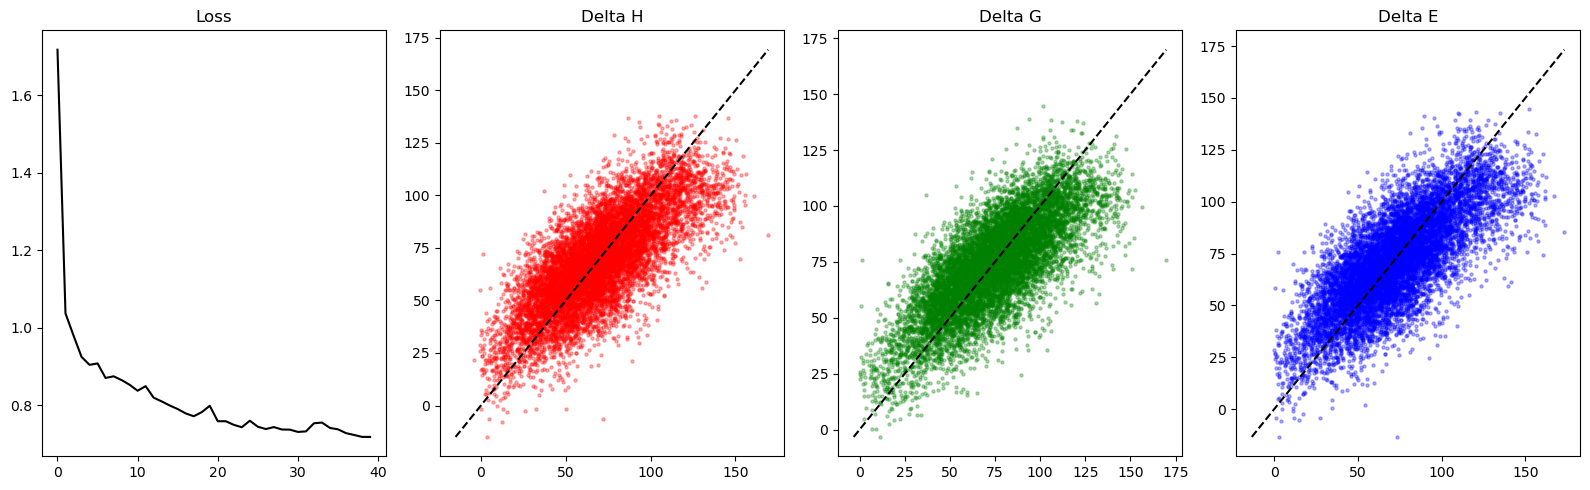

In [18]:
if __name__ == "__main__":
    import os
    base_dir = r"C:\Users\yeseo\OneDrive\OneDrive - personal\서류&파일\University of Seoul\연구\Code"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")
    
    if os.path.exists(MY_H5_PATH):
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)
        
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()
    else:
        print("파일을 찾을 수 없습니다.")

In [19]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)
    
    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])
        
        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))
        
        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)
        
        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)
        
        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지
        
        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)
    
    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")
    
    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.
    
    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 14.7590    | 18.6691    | 348.5364   | 0.5617    
Delta G (ΔG)    | 13.8212    | 17.4696    | 305.1878   | 0.5673    
Delta E (ΔE)    | 15.3151    | 19.4040    | 376.5154   | 0.5612    
⭐ Average MAE: 14.6318 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

